In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader

def unpickle(file): 
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Directory where the CIFAR-10 batches are stored
data_dir = 'data/cifar-10-batches-py'

# List to store all data batches
data_list = []

# List to store all labels from batches
labels_list = []

# There are 5 data batches named data_batch_1, data_batch_2, ..., data_batch_5
for i in range(1, 6):
    file_path = os.path.join(data_dir, f'data_batch_{i}')
    batch_data = unpickle(file_path)
    data_list.append(batch_data[b'data'])
    labels_list.extend(batch_data[b'labels'])

# Convert the list of data batches to a single numpy array
data_array = np.vstack(data_list)
labels_array = np.array(labels_list)

# Convert numpy arrays to PyTorch tensors
data_tensor = torch.tensor(data_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)

# Normalize the data to [0, 1] range
data_tensor = data_tensor / 255.0

# Reshape the data_tensor to (num_samples, channels, height, width)
data_tensor = data_tensor.view(-1, 3, 32, 32)

class CIFAR10Dataset(Dataset):
    def __init__(self, data_tensor, labels_tensor, transform=None):
        self.data = data_tensor
        self.labels = labels_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        
        # Convert tensor to PIL Image
        sample = to_pil_image(sample)
        
        if self.transform:
            sample = self.transform(sample)

        return sample, label


# Define the recommended transformations for data augmentation
transform = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 normalization
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 normalization
])

test_file_path = 'data/cifar-10-batches-py/test_batch'
test_batch_data = unpickle(test_file_path)
test_data_array = np.array(test_batch_data[b'data'])
test_labels_array = np.array(test_batch_data[b'labels'])

# Convert to PyTorch tensors
test_data_tensor = torch.tensor(test_data_array, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_array, dtype=torch.long)

# Normalize and reshape
test_data_tensor = test_data_tensor / 255.0
test_data_tensor = test_data_tensor.view(-1, 3, 32, 32)
# Create the custom dataset
train_dataset = CIFAR10Dataset(data_tensor, labels_tensor, transform=transform)
test_dataset = CIFAR10Dataset(test_data_tensor, test_labels_tensor, transform=test_transform)

# Create the DataLoader
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()  # Add ReLU layer
        
        # Max Pooling Layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()  # Add ReLU layer
        
        # Max Pooling Layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layer 1
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()  # Add ReLU layer
        
        # Output Layer
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolutional Layer 1
        x = self.pool1(self.relu1(self.batch_norm1(self.conv1(x))))
        
        # Convolutional Layer 2
        x = self.pool2(self.relu2(self.batch_norm2(self.conv2(x))))
        
        # Flatten Layer
        x = x.view(-1, 64 * 8 * 8)
        
        # Fully Connected Layer 1
        x = self.relu3(self.batch_norm3(self.fc1(x)))
        
        # Output Layer
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

# Create an instance of the CNNModel
model = CNNModel()

# Print the model architecture
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (batch_norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [4]:
import torch.optim as optim

# Move the model to the CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = CNNModel().to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer (using Adam optimizer)
optimizer = optim.SGD(model.parameters(), lr=.02, momentum=.95, weight_decay=0.001)
#optimizer = optim.AdamW(model.parameters(), lr=.01, weight_decay=0.001)

# Number of training iterations
num_iterations = 10

# Training loop
for epoch in range(num_iterations):
    running_loss = 0.0
    
    # Iterate over the training dataset
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        # Move inputs and labels to the CUDA device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:  # Print every 100 mini-batches
            print('[%d, %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Training finished!')

cuda
[1,    10] Loss: 0.198
[1,    20] Loss: 0.169
[1,    30] Loss: 0.152
[1,    40] Loss: 0.143
[1,    50] Loss: 0.134
[1,    60] Loss: 0.133
[1,    70] Loss: 0.129
[1,    80] Loss: 0.127
[1,    90] Loss: 0.120
[1,   100] Loss: 0.119
[1,   110] Loss: 0.115
[1,   120] Loss: 0.109
[1,   130] Loss: 0.109
[1,   140] Loss: 0.108
[1,   150] Loss: 0.109
[1,   160] Loss: 0.103
[1,   170] Loss: 0.105
[1,   180] Loss: 0.099
[1,   190] Loss: 0.101
[2,    10] Loss: 0.090
[2,    20] Loss: 0.091
[2,    30] Loss: 0.090
[2,    40] Loss: 0.092
[2,    50] Loss: 0.093
[2,    60] Loss: 0.093
[2,    70] Loss: 0.093
[2,    80] Loss: 0.087
[2,    90] Loss: 0.089
[2,   100] Loss: 0.086
[2,   110] Loss: 0.084
[2,   120] Loss: 0.086
[2,   130] Loss: 0.088
[2,   140] Loss: 0.087
[2,   150] Loss: 0.089
[2,   160] Loss: 0.084
[2,   170] Loss: 0.087
[2,   180] Loss: 0.084
[2,   190] Loss: 0.087
[3,    10] Loss: 0.075
[3,    20] Loss: 0.074
[3,    30] Loss: 0.071
[3,    40] Loss: 0.072
[3,    50] Loss: 0.072
[3,   

In [5]:
# Evaluate the model on the test set
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to the CUDA device if available
            inputs, labels = inputs.cuda(), labels.cuda()

            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            # Update the count of correct predictions
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    average_loss = total_loss / len(test_loader)

    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Average Test Loss: {average_loss:.4f}')

# Assuming your model, criterion, and test_loader are already defined
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Evaluate the model on the test set
evaluate_model(model, test_loader, criterion)

Test Accuracy: 67.16%
Average Test Loss: 1.0987


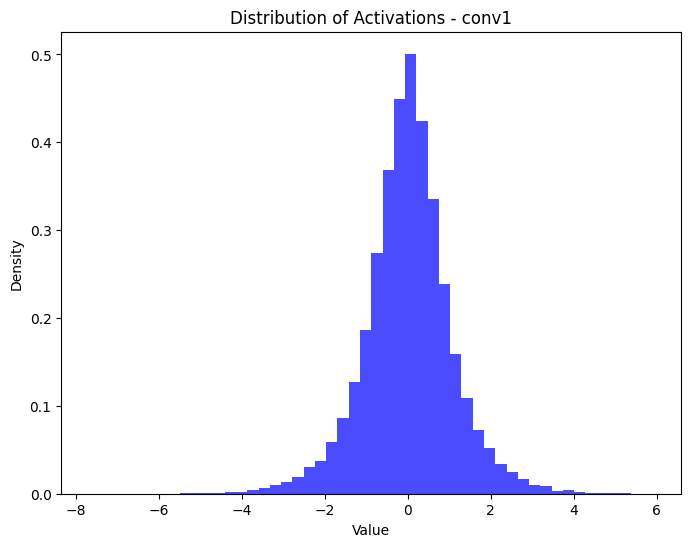

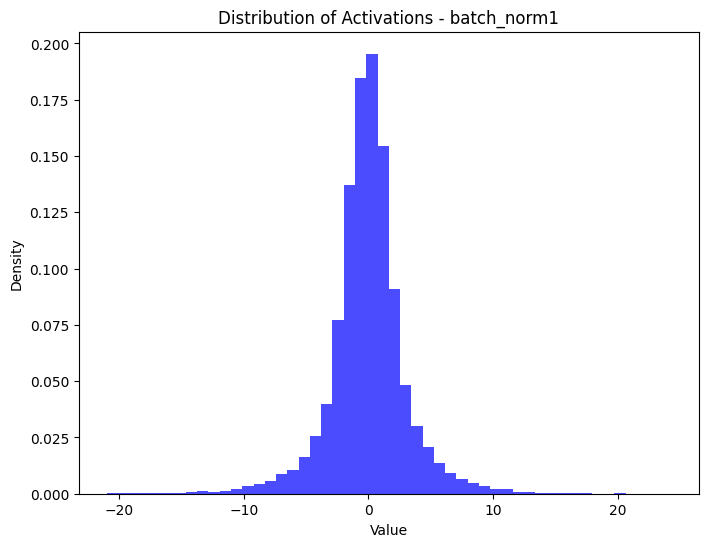

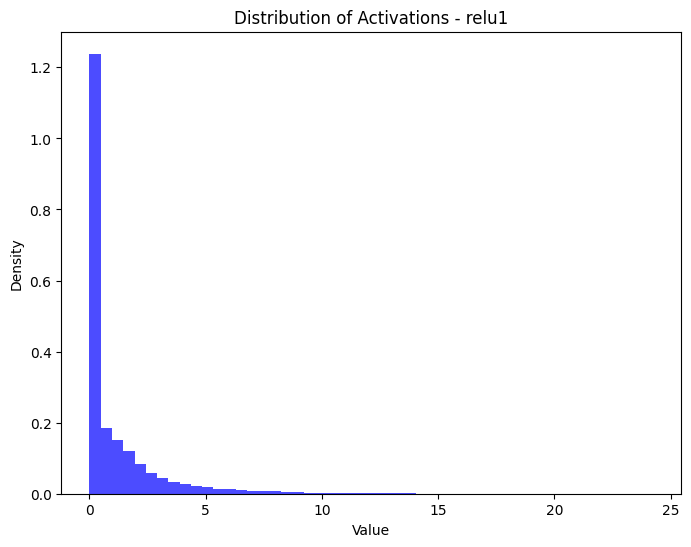

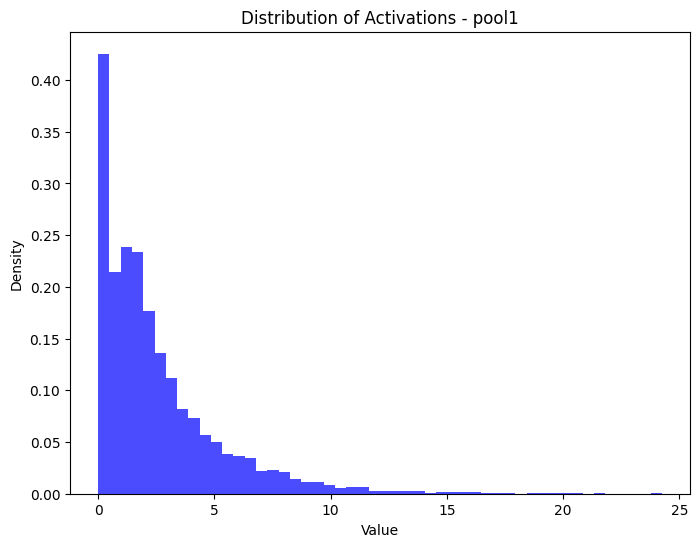

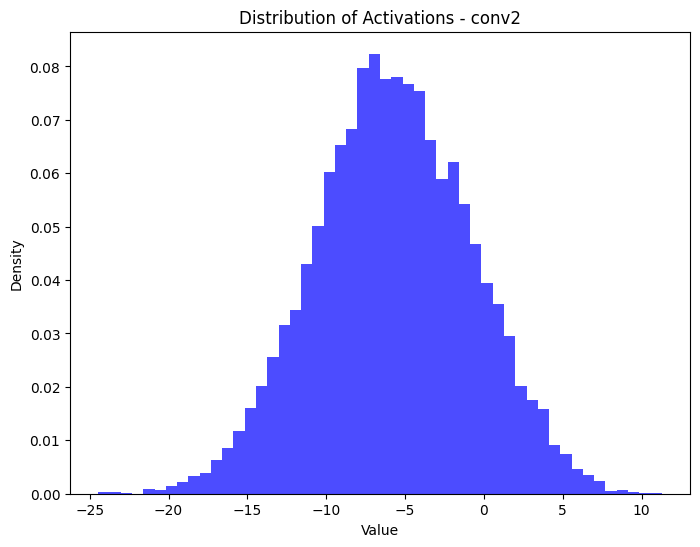

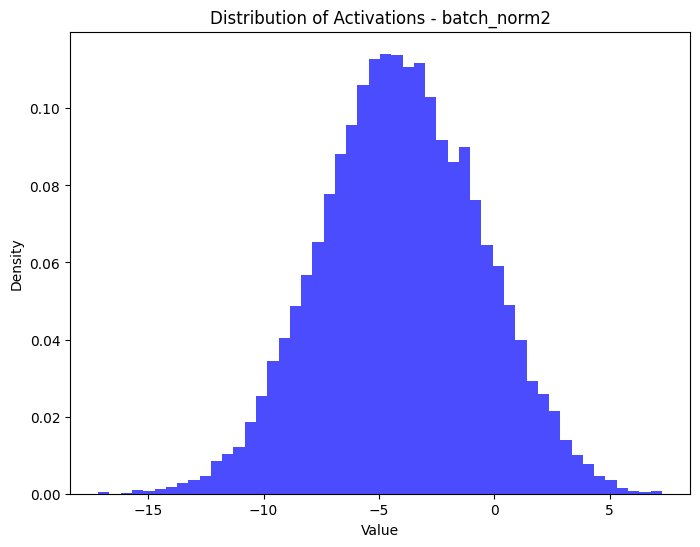

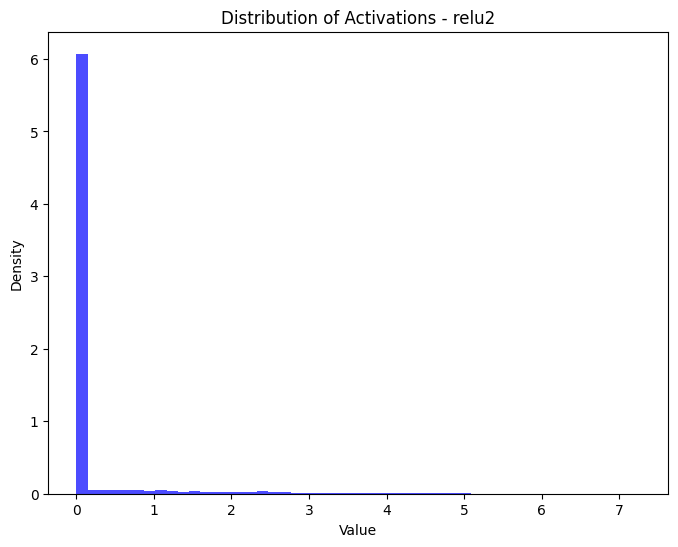

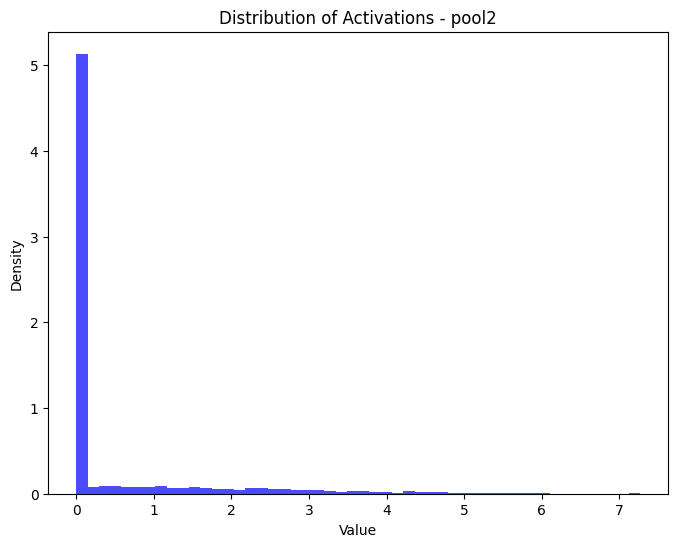

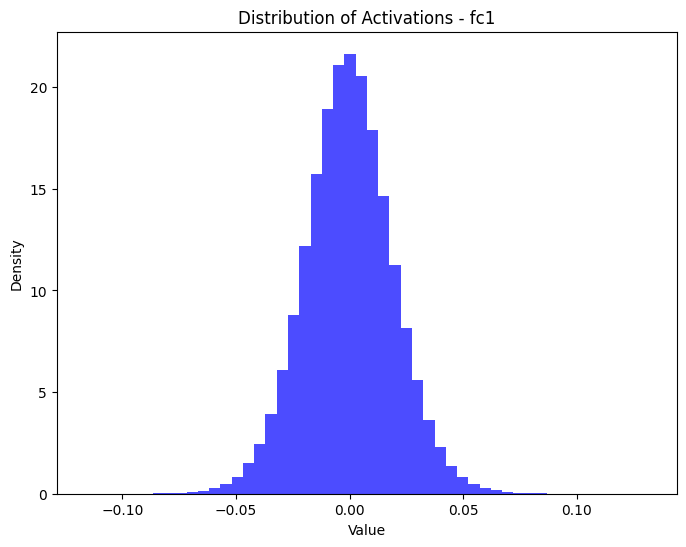

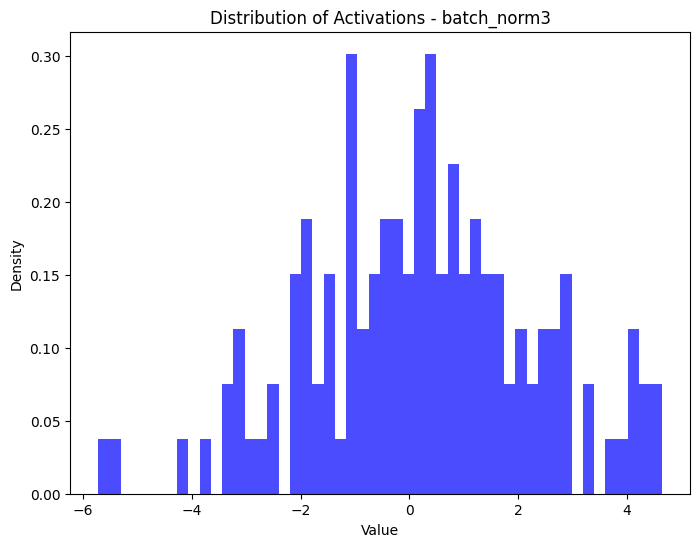

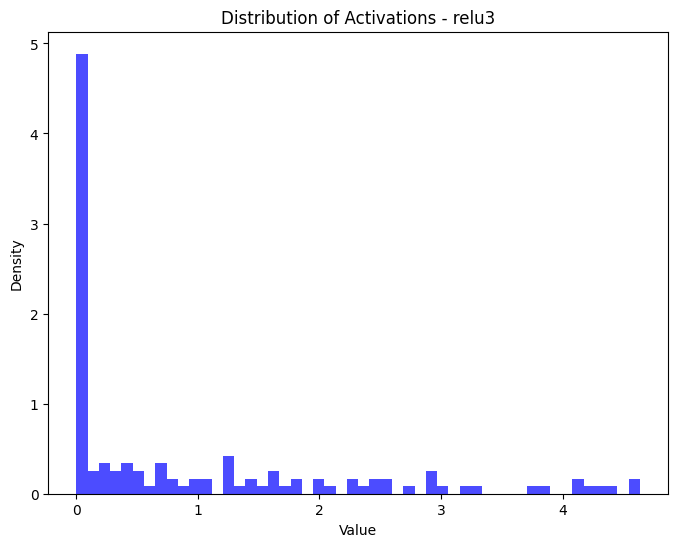

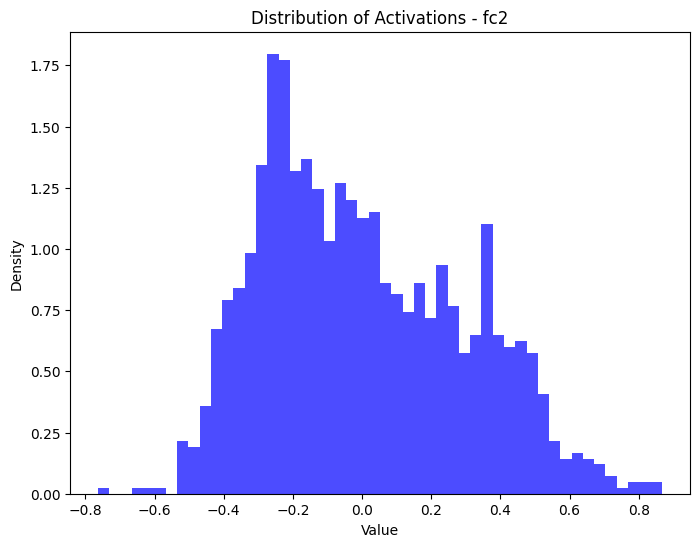

In [6]:
import matplotlib.pyplot as plt

# Generate random input data for visualization
dummy_input = torch.randn(1, 3, 32, 32)  # Batch size of 10
dummy_input_BN1D = torch.randn(1, 128)
# Forward pass to capture activations
activations = []

with torch.no_grad():
    for layer_name, layer in model.named_children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ReLU) or isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.MaxPool2d):
            dummy_input = layer(dummy_input.to(device))
            activation = dummy_input.clone().detach().cpu().numpy()
            plt.figure(figsize=(8, 6))
            plt.hist(activation.flatten(), bins=50, density=True, alpha=0.7, color='blue')
            plt.title(f'Distribution of Activations - {layer_name}')
            plt.xlabel('Value')
            plt.ylabel('Density')
            plt.show()
        elif isinstance(layer, nn.BatchNorm1d):
            dummy_input = layer(dummy_input_BN1D.to(device))
            activation = dummy_input.clone().detach().cpu().numpy()
            plt.figure(figsize=(8, 6))
            plt.hist(activation.flatten(), bins=50, density=True, alpha=0.7, color='blue')
            plt.title(f'Distribution of Activations - {layer_name}')
            plt.xlabel('Value')
            plt.ylabel('Density')
            plt.show()
        else:
            plt.figure(figsize=(8, 6))
            plt.hist(layer.weight.flatten().cpu().numpy(), bins=50, density=True, alpha=0.7, color='blue')
            plt.title(f'Distribution of Activations - {layer_name}')
            plt.xlabel('Value')
            plt.ylabel('Density')
            plt.show()

conv1 filters


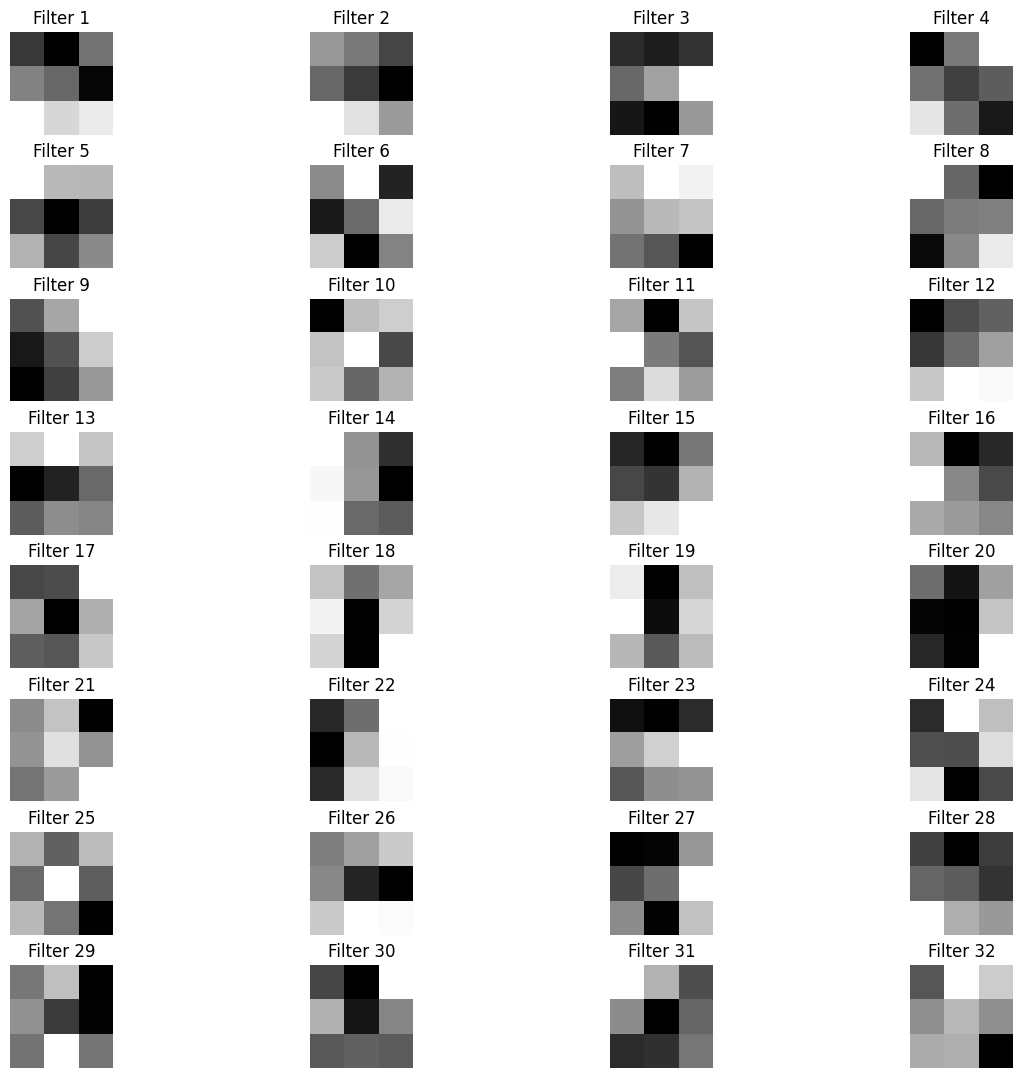

conv2 filters


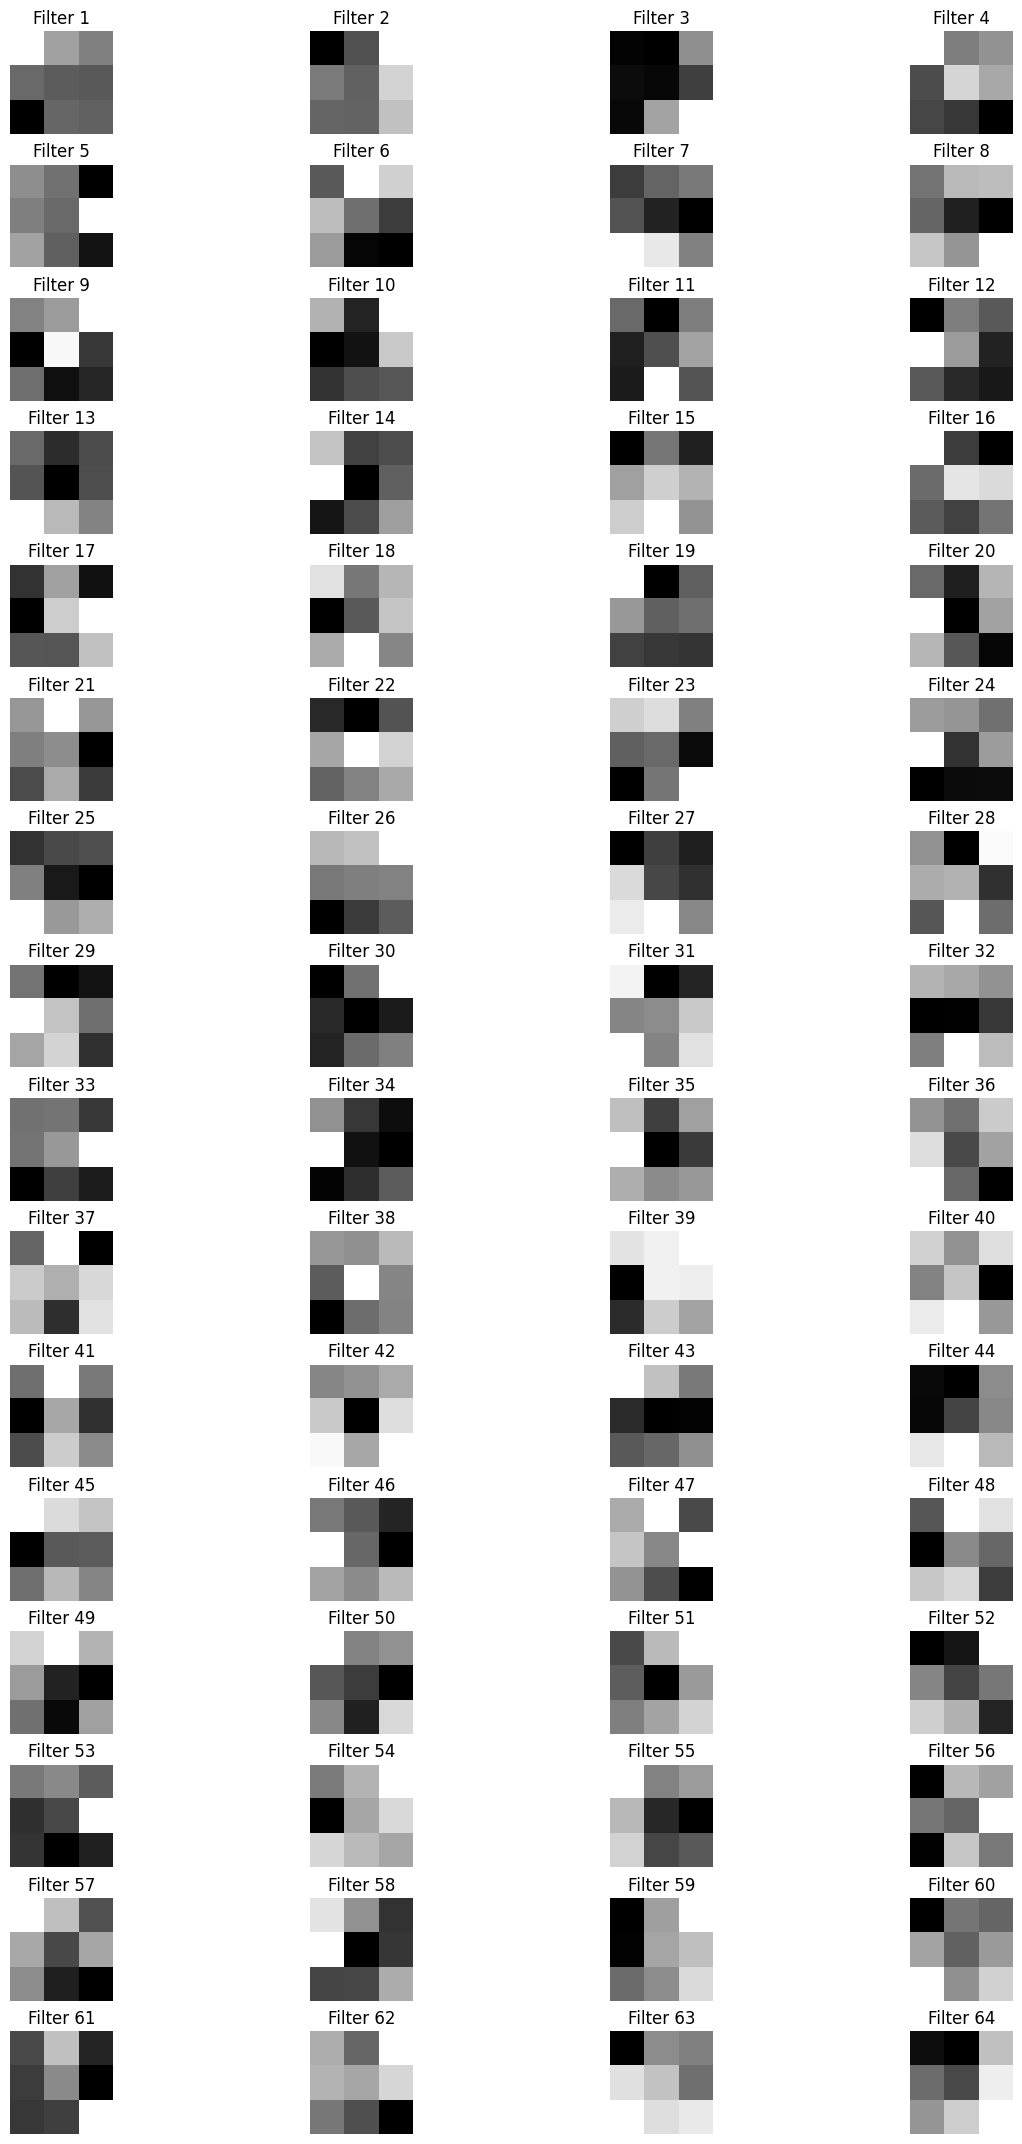

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the filter kernels
def visualize_kernels(model, layer_name, num_kernels=6):
    # Extract the weights from the specified layer
    layer_weights = model._modules[layer_name].weight.data.cpu().numpy()

    # Get the number of input channels for the layer
    num_input_channels = layer_weights.shape[1]

    # Specify a fixed number of columns for subplots
    num_cols = 4

    # Calculate the number of rows needed based on the number of kernels and columns
    num_rows = int(np.ceil(num_kernels / num_cols))

    # Adjust the figure size based on the number of rows
    figsize = (12, 8 * (num_rows / 6))  # Adjust the multiplier based on your preference

    # Create a figure and subplots with adjusted layout
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, constrained_layout=True)

    # Plot the filter kernels
    for i in range(num_kernels):
        # Calculate the position in the subplot grid
        row_idx = i // num_cols
        col_idx = i % num_cols

        # Extract the filter from each kernel
        kernel = layer_weights[i, 0]

        # Plot the kernel as a grayscale image with filter number label
        axes[row_idx, col_idx].imshow(kernel, cmap='gray', aspect='equal')  # Set aspect ratio to 'equal'
        axes[row_idx, col_idx].axis('off')
        axes[row_idx, col_idx].set_title(f'Filter {i + 1}')

    # Remove empty subplots
    for i in range(num_kernels, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    plt.show()

# Assuming you have a Convnet model
num_classes = 10  # Replace with the number of classes in your specific task

# Visualize the filter kernels in the first convolutional layer (conv1)
print("conv1 filters")
visualize_kernels(model, 'conv1', num_kernels=32)

# Visualize the filter kernels in the second convolutional layer (conv2)
print("conv2 filters")
visualize_kernels(model, 'conv2', num_kernels=64)

Output of conv1 filters applied to an image


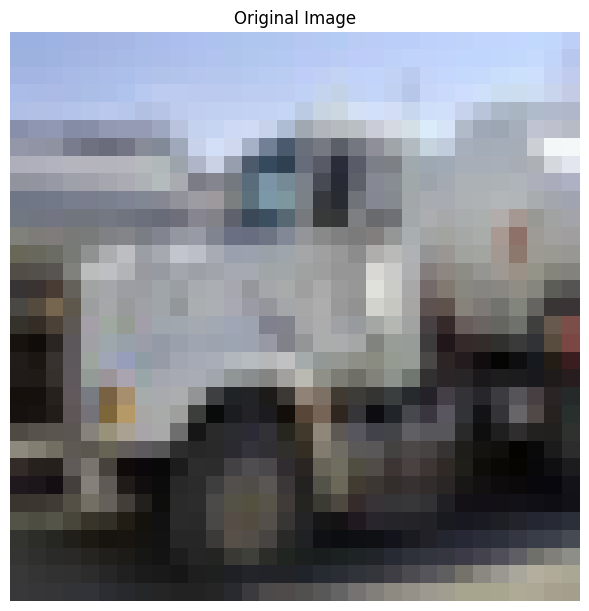

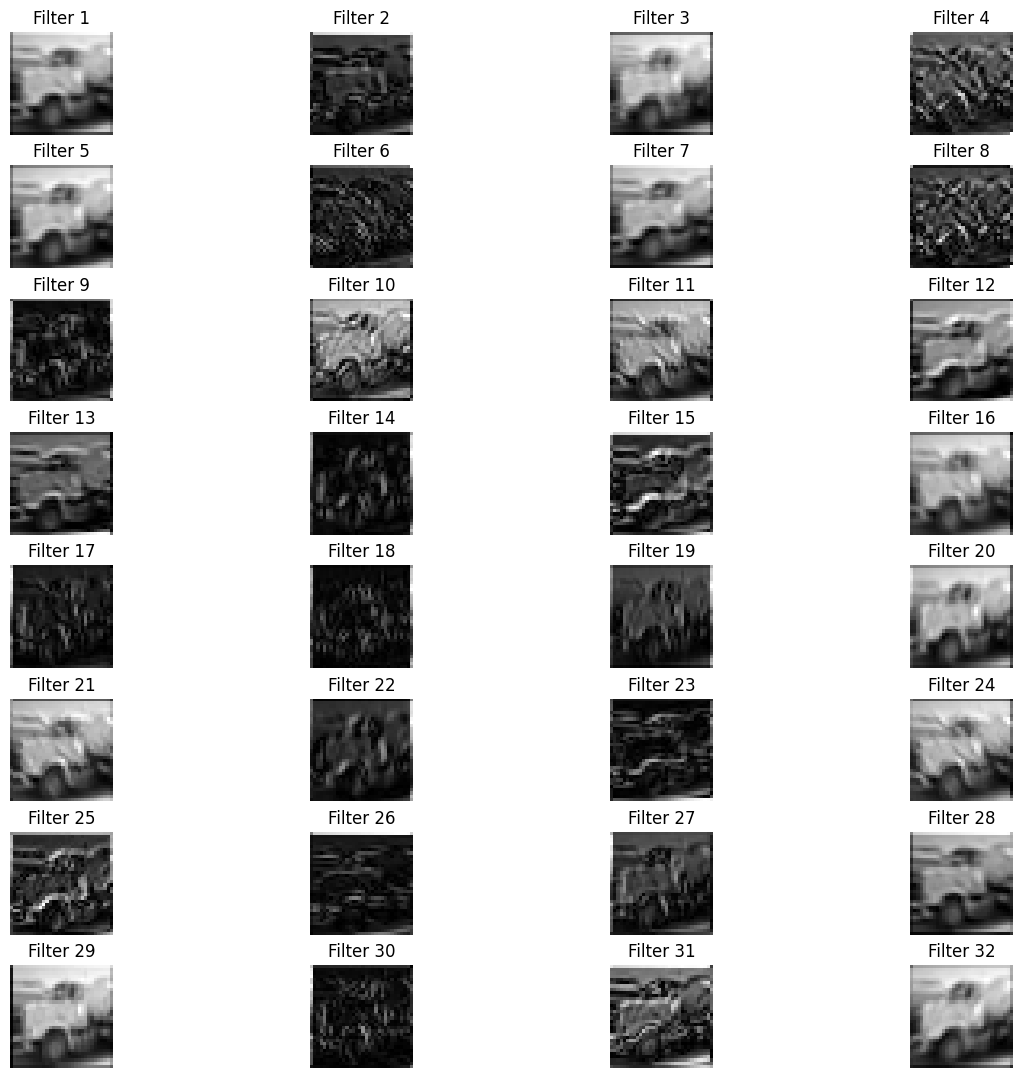

Output of conv2 filters applied to an image


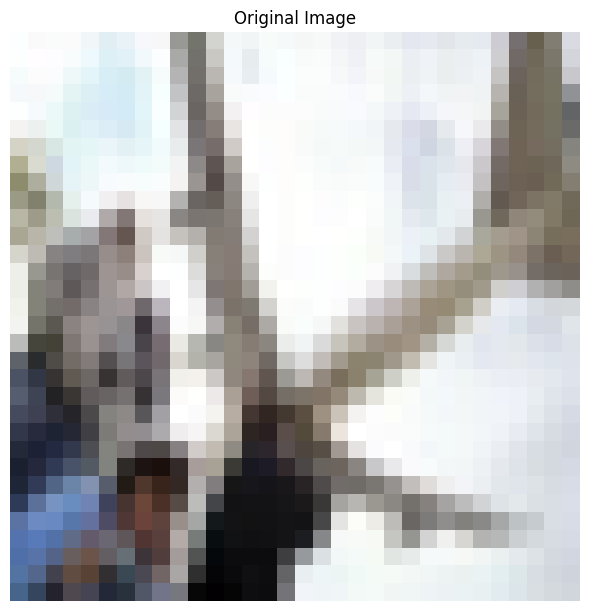

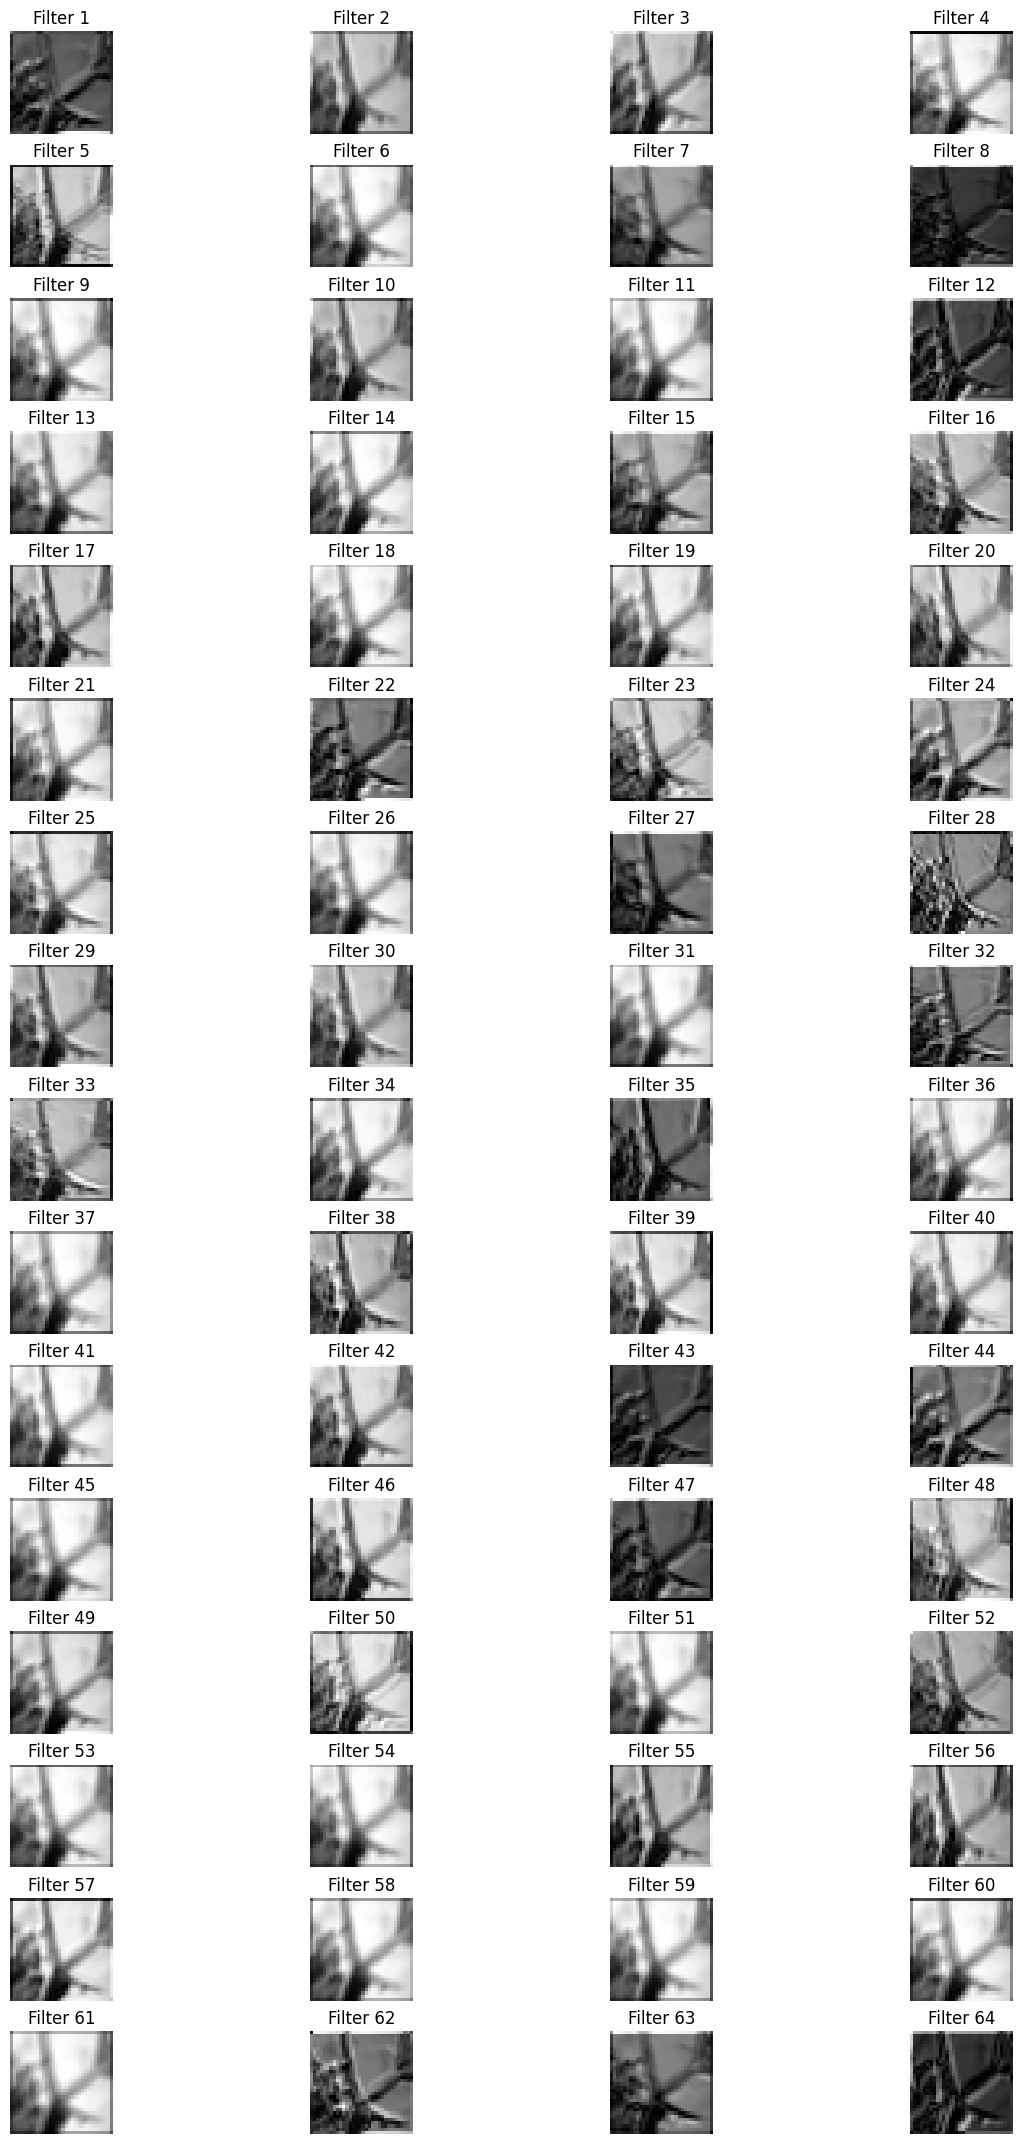

In [13]:
from scipy.signal import convolve2d

def visualize_kernel_output(model, layer_name, dataloader, num_kernels=6):
    # Extract the weights from the specified layer
    layer_weights = model._modules[layer_name].weight.data.cpu().numpy()

    # Get the number of input channels for the layer
    num_input_channels = layer_weights.shape[1]

    # Specify a fixed number of columns for subplots
    num_cols = 4

    # Calculate the number of rows needed based on the number of kernels and columns
    num_rows = int(np.ceil(num_kernels / num_cols))

    # Adjust the figure size based on the number of rows
    figsize = (12, 8 * (num_rows / 6))  # Adjust the multiplier based on your preference

    # Create a figure and subplots with adjusted layout for original image
    fig_original, ax_original = plt.subplots(figsize=(6, 6), constrained_layout=True)

    # Iterate through the dataloader to get an image
    for images, _ in dataloader:
        # Choose the first image from the batch
        image = images[0].numpy().transpose((1, 2, 0))  # Convert to NumPy and adjust dimensions
        image = (image - image.min()) / (image.max() - image.min())  # Normalize image

        # Plot the original image
        ax_original.imshow(image)
        ax_original.axis('off')
        ax_original.set_title('Original Image')

        break  # Break after processing the first batch

    # Create a figure and subplots with adjusted layout for convolutional outputs
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, constrained_layout=True)

    # Apply the filters to the image and plot the outputs
    for i in range(num_kernels):
        # Calculate the position in the subplot grid
        row_idx = i // num_cols
        col_idx = i % num_cols

        # Extract the filter from each kernel
        kernel = layer_weights[i, 0]

        # Apply the filter to the image using scipy.signal.convolve2d
        output = np.abs(convolve2d(image[:, :, 0], kernel, mode='same'))

        # Plot the output as a grayscale image with filter number label
        axes[row_idx, col_idx].imshow(output, cmap='gray', aspect='equal')  # Set aspect ratio to 'equal'
        axes[row_idx, col_idx].axis('off')
        axes[row_idx, col_idx].set_title(f'Filter {i + 1}')

    plt.show()

# Assuming you have a Convnet model
num_classes = 10  # Replace with the number of classes in your specific task

# Visualize the original image and the output of the filters in the first convolutional layer (conv1)
print("Output of conv1 filters applied to an image")
visualize_kernel_output(model, 'conv1', train_loader, num_kernels=32)

# Visualize the original image and the output of the filters in the second convolutional layer (conv2)
print("Output of conv2 filters applied to an image")
visualize_kernel_output(model, 'conv2', train_loader, num_kernels=64)

Averaged kernels for conv1


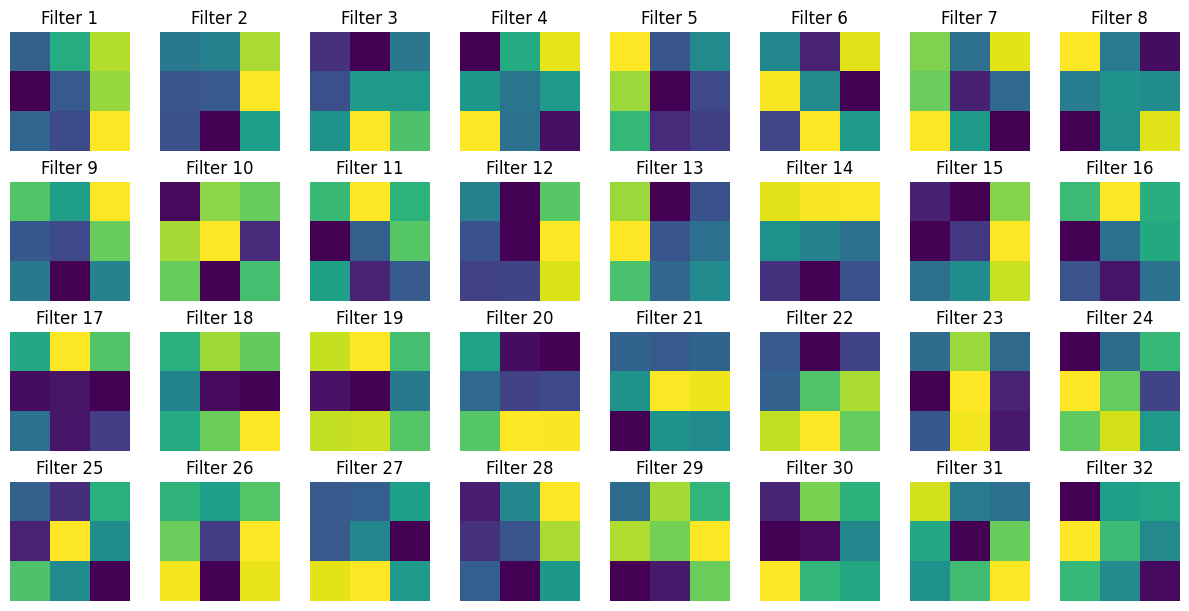

Averaged kernels for conv2


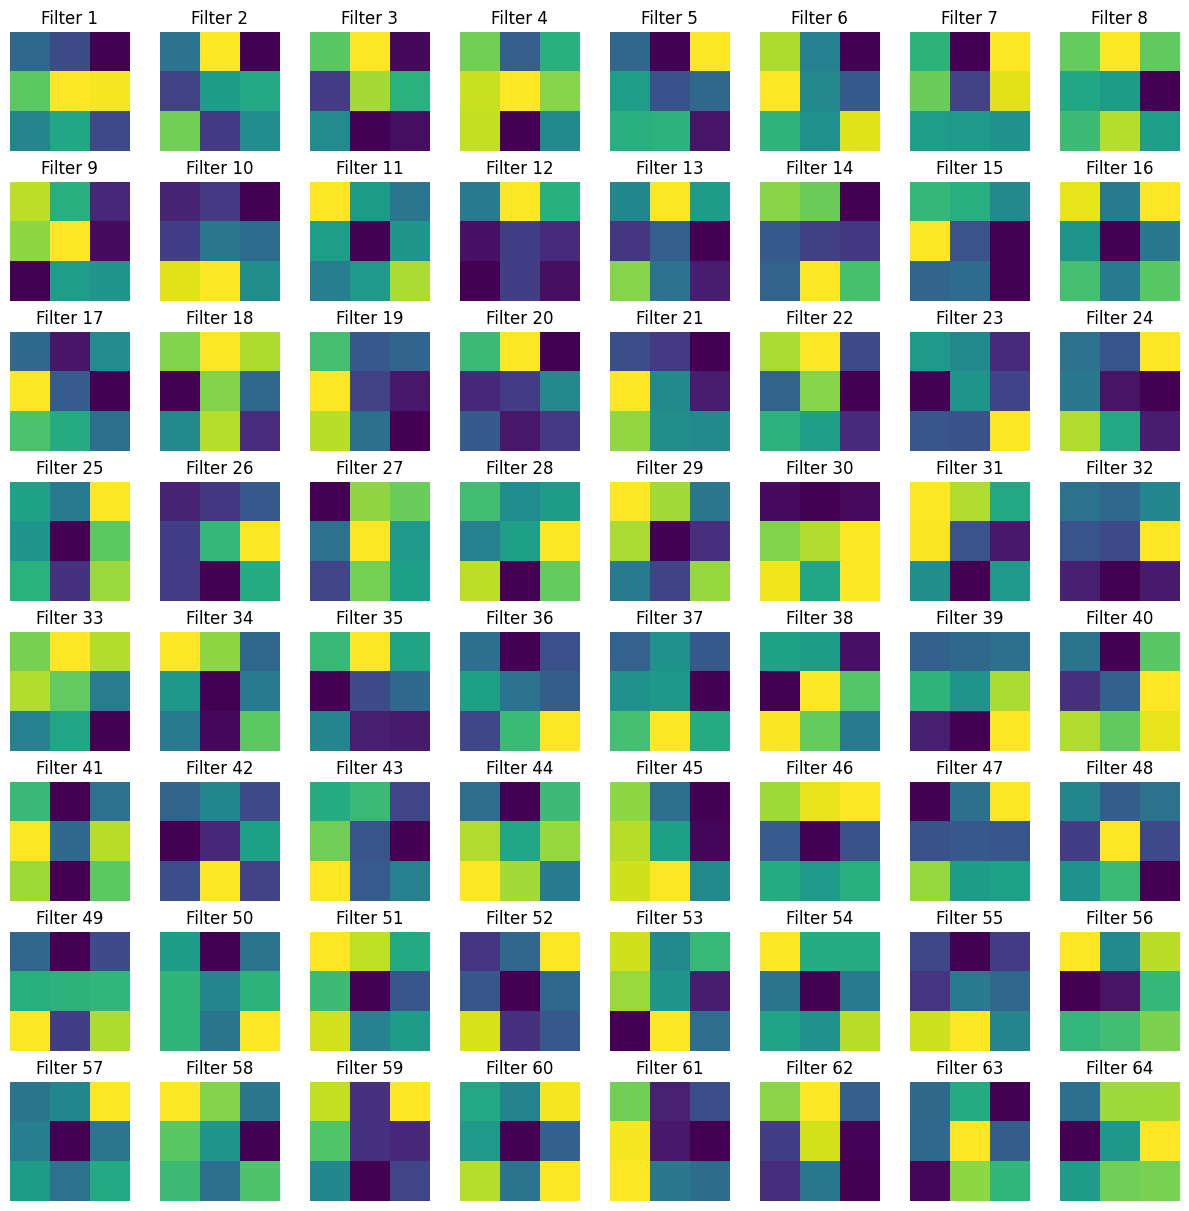

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_average_kernels_rgb(model, layer_name, num_filters=32):
    # Extract the weights from the specified layer
    layer_weights = model._modules[layer_name].weight.data.cpu().numpy()

    # Calculate the element-wise average across all filters in each channel
    avg_kernels = np.mean(layer_weights[:, :num_filters], axis=1, keepdims=True)

    # Ensure the channels are the first dimension
    if avg_kernels.shape[-1] < avg_kernels.shape[0]:
        avg_kernels = avg_kernels.transpose((0, 3, 1, 2))

    # Plot the averaged kernels as a 3x3 RGB image with 8 filters per row
    num_rows = int(np.ceil(num_filters / 8))
    num_cols = min(8, num_filters)

    # Adjust the figure size based on the number of rows and columns
    figsize = (12, 12 * (num_rows / 8))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, constrained_layout=True)

    for i in range(min(num_filters, avg_kernels.shape[0])):
        # Normalize each channel to [0, 1]
        max_val = np.max(avg_kernels[i])
        min_val = np.min(avg_kernels[i])

        # Avoid division by zero
        if (max_val - min_val) == 0:
            normalized_kernel = avg_kernels[i]
        else:
            normalized_kernel = (avg_kernels[i] - min_val) / (max_val - min_val)

        # Plot each normalized and clipped averaged kernel as an RGB image
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].imshow(normalized_kernel.squeeze(), aspect='equal')
        axes[row_idx, col_idx].axis('off')
        axes[row_idx, col_idx].set_title(f'Filter {i + 1}')

    plt.show()

# Assuming you have a CNN model
num_classes = 10  # Replace with the number of classes in your specific task

# Visualize the averaged kernels for the first convolutional layer (conv1) as RGB
print("Averaged kernels for conv1")
visualize_average_kernels_rgb(model, 'conv1', num_filters=32)

# Visualize the averaged kernels for the second convolutional layer (conv2) as RGB
print("Averaged kernels for conv2")
visualize_average_kernels_rgb(model, 'conv2', num_filters=64)

Output of conv1 filters applied to an image


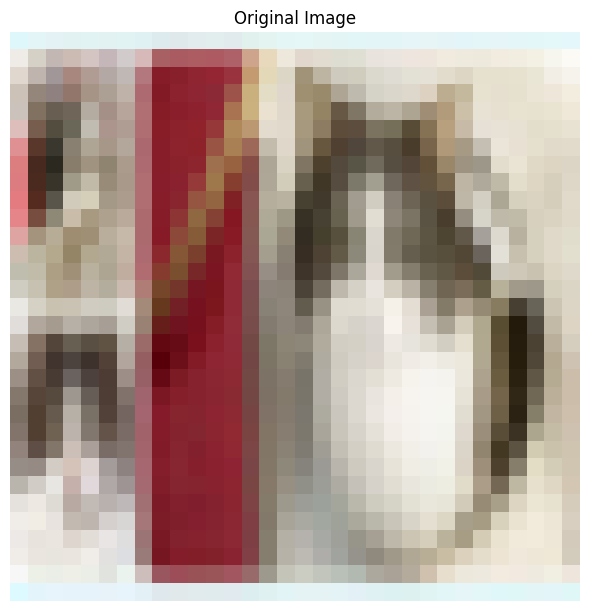

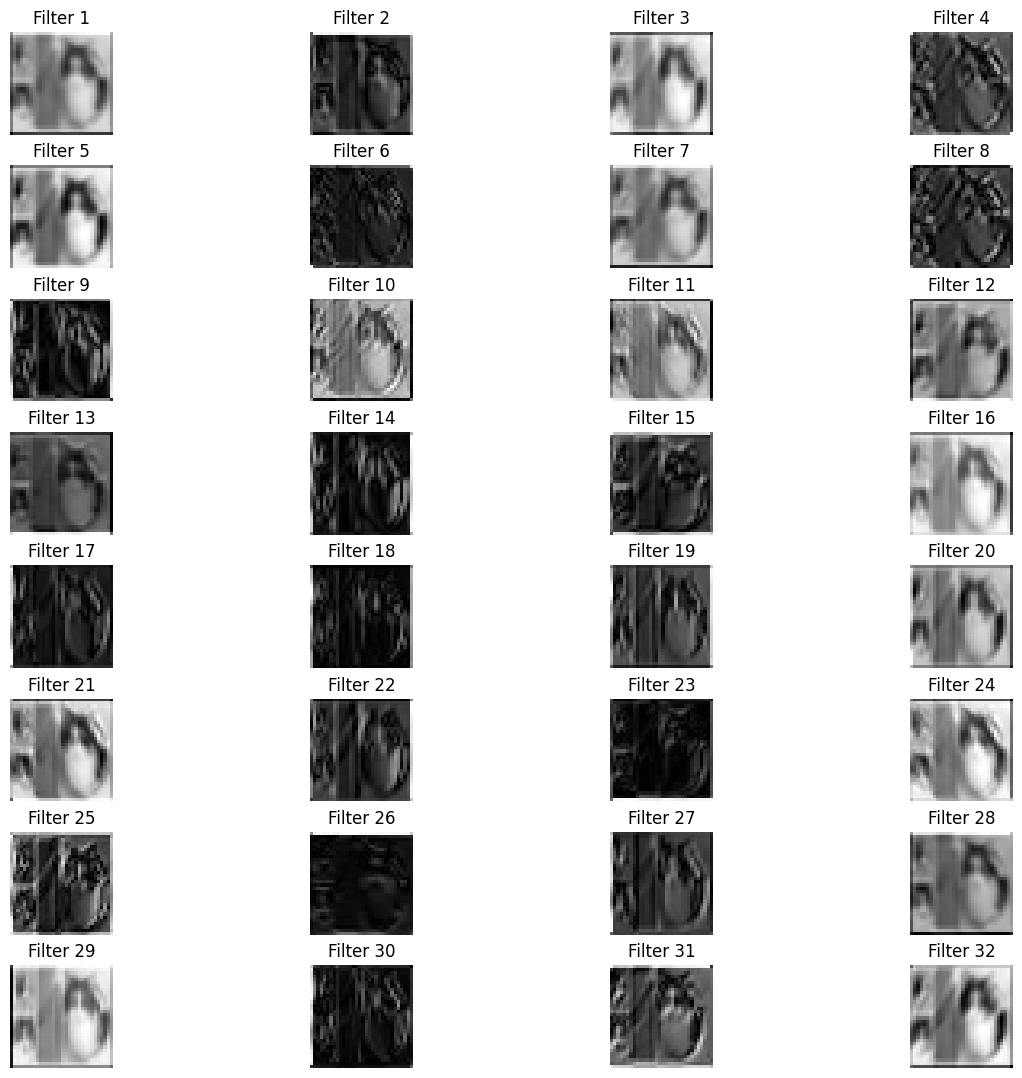

Output of conv2 filters applied to an image


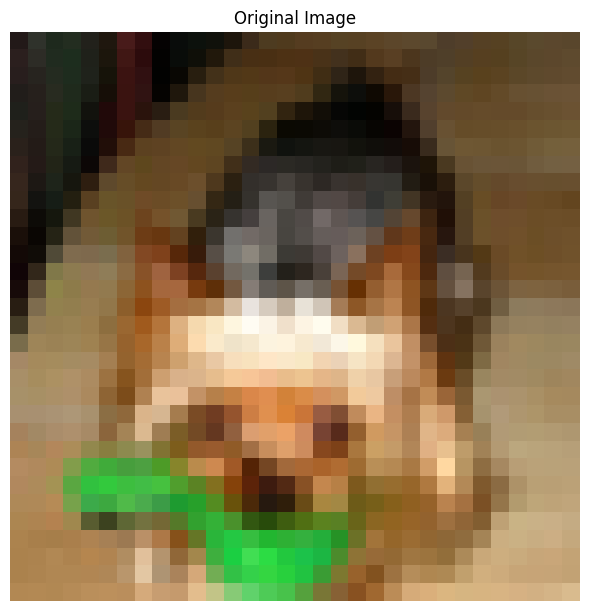

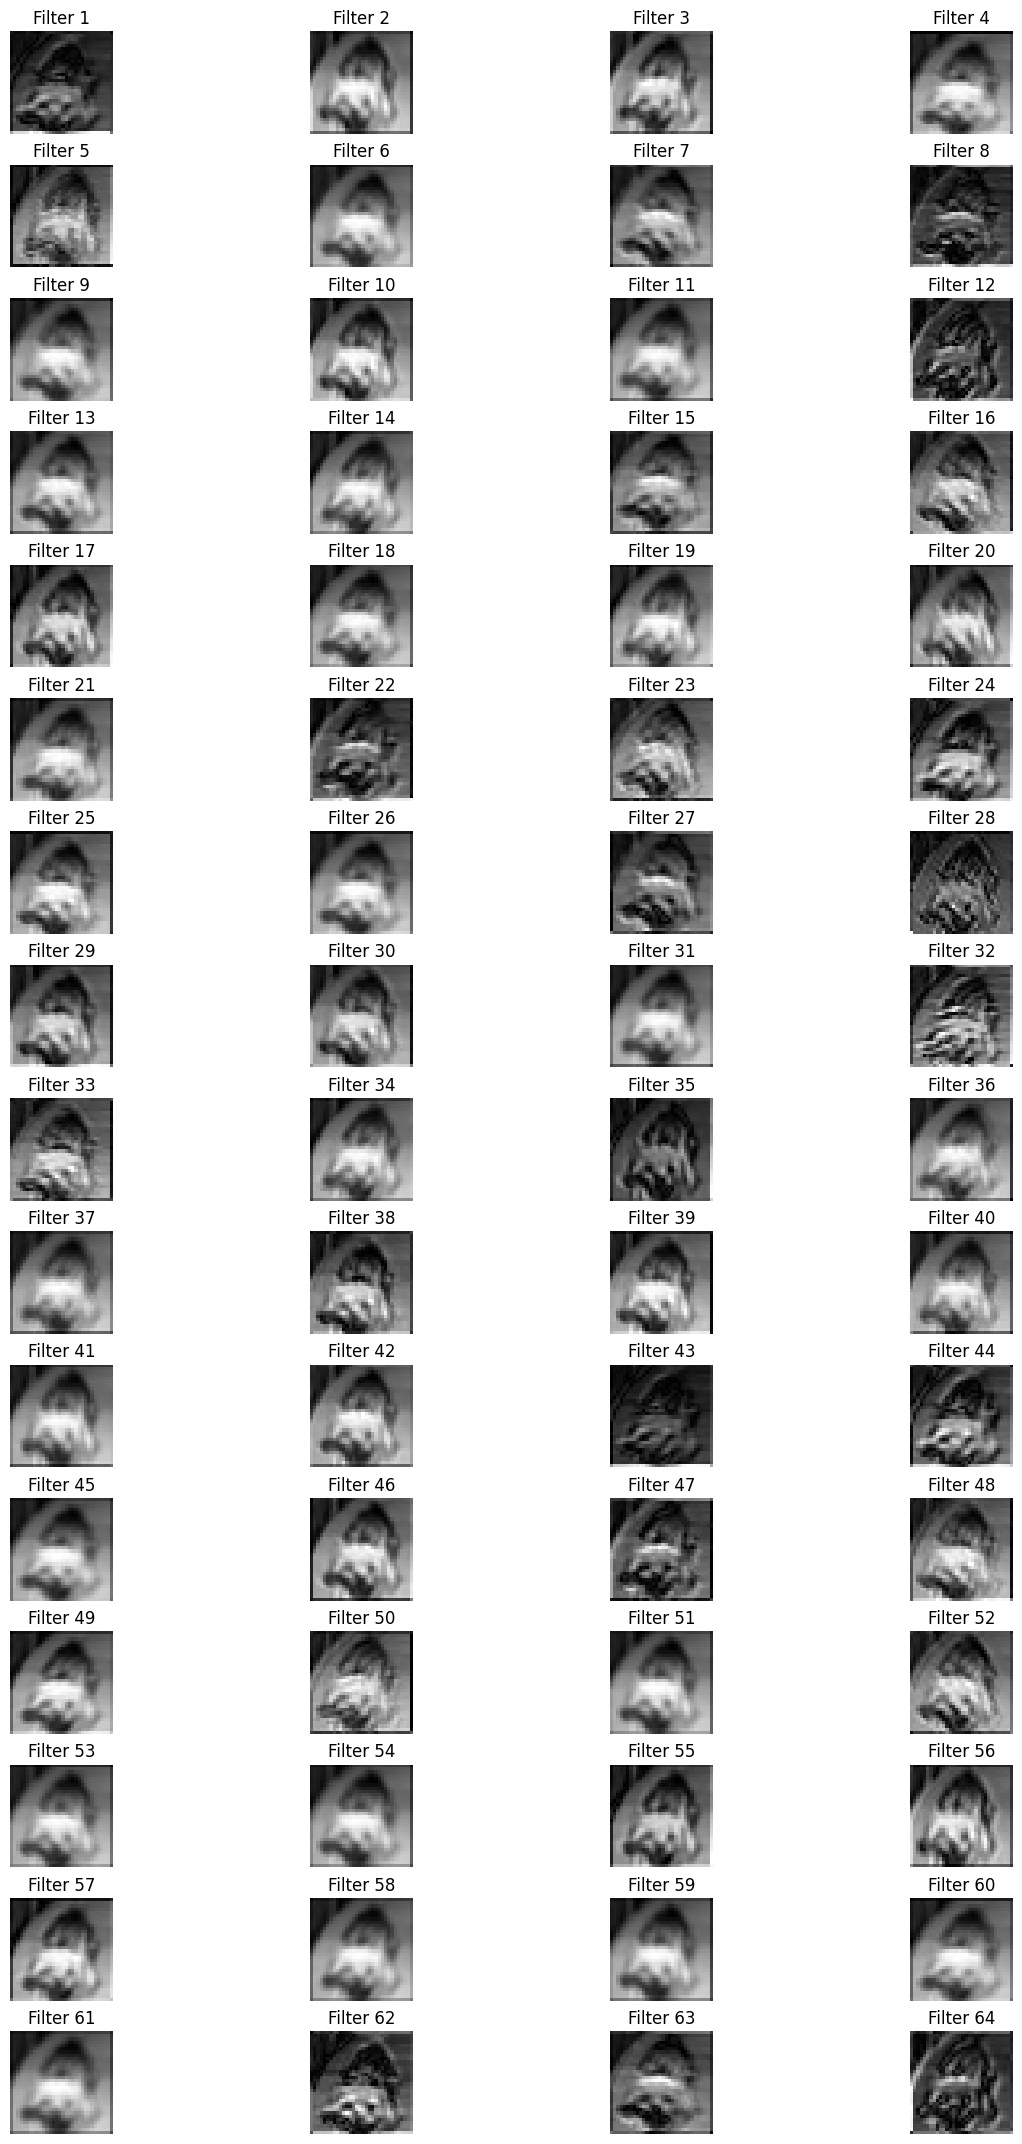